# DRUG USE CLASSIFICATION ANALYSIS

---

# Functions

In [3]:
def binary_train_test_split( X, Y, training=[100,100], testing=[100,100],
                         fill_train_1=False, equal_train_0=False,
                         replace=False, return_index=False, report=True
                       ):
    
    idx_0, idx_1 = Y[Y==0].index.copy(), Y[Y==1].index.copy()

    test_0 = list(np.random.choice( idx_0, testing[0], replace=replace ))
    test_1 = list(np.random.choice( idx_1, testing[1], replace=replace ))

    idx_0 = list( set(idx_0).difference(test_0) )
    idx_1 = list( set(idx_1).difference(test_1) )
    
    if fill_train_1: training[1] = len(idx_1)
    if equal_train_0: training[0] = training[1]
        
    train_0 = list(np.random.choice( idx_0, training[0], replace=replace ))
    train_1 = list(np.random.choice( idx_1, training[1], replace=replace ))

    test_index = test_0 + test_1
    train_index = train_0 + train_1
    
    X_train = X.loc[train_index]; X_test = X.loc[test_index]
    Y_train = Y.loc[train_index]; Y_test = Y.loc[test_index]

    report_df = pd.concat(map(pd.value_counts, [Y_train, Y_test]), 1)
    report_df.columns=['Train Set', 'Test Set']; report_df.index.name='class';
    if report: display(report_df)
    
    if return_index:
        return train_index, test_index
    
    return X_train, X_test, Y_train, Y_test

In [15]:
def split(X, Y, subclass_size, report=True):

    test_size = int( Y[Y==1].shape[0] * subclass_size)
    
    train_index, test_index = binary_train_test_split( 
                                                         X, Y, 
                                                         training=[None, None], testing=[test_size, test_size],
                                                         fill_train_1=True, equal_train_0=True,
                                                         replace=False, return_index=True, report=report
                                                     )
    
    return X.loc[train_index], X.loc[test_index], Y.loc[train_index], Y.loc[test_index]


In [16]:
def split_train_eval(X, Y, models=None, subclass_size=0.25, report=True, new_split=False):
    
    # Training and Testing Splits Sampling -----------------------------------------------------------------
    if not new_split: X_train, X_test, Y_train, Y_test = split(X, Y, subclass_size, report=report)
    
    # Modeling/Evaluating ------------------------------------------------------------------
    
    if type(models)==type(None): models = dict( sklearn.utils.all_estimators(type_filter='classifier') )
    models_names = list(models.keys()); n_models = len(models_names)
    
    scrs, fail, cnt = {}, [], 0
    for name in models_names:
        if report: cnt+=1; clear_output(wait=True); print(f'{cnt}/{n_models} models evaluated')
        try:        
            model = models[name]()
            
            if new_split: 
                X_train, X_test, Y_train, Y_test = split(X, Y, subclass_size, report=report)
            
            model.fit(X_train, Y_train)
            yhat = model.predict(X_test)

            cls_report = cr(Y_test, yhat, output_dict=True)
            scrs[name] = [
                            cls_report['accuracy'],
                            cls_report['macro avg']['f1-score'],
                            cls_report['0']['recall'],
                            cls_report['0']['f1-score'],
                            cls_report['1']['recall'],
                            cls_report['1']['f1-score']
                         ]    
        except:
            fail.append(name)

    metrics = ['accuracy', 'f1-score', 'recall - 0',
               'f1-score - 0', 'recall - 1', 'f1-score - 1']
    evaluation = pd.DataFrame(scrs, index=metrics)

    # Reporting ----------------------------------------------------------------------------------------
    if report:
        n_top = int(evaluation.T.shape[0]/4)
        top_scrs = evaluation.T.sort_values(by='f1-score', ascending=False).head(n_top)

        fig = plt.figure(figsize=(6.5, 2.6))
        sns.heatmap(top_scrs, annot=True,
                    vmin=top_scrs['accuracy'].min(),
                    vmax=top_scrs['accuracy'].max())
        plt.show()

    return evaluation

In [17]:
def HeatMap(df, figsize=(6.5, 2.6), col_ref='f1-score'):
    
    fig = plt.figure(figsize=(6.5, 2.6))
    sns.heatmap(df, annot=True,
                vmin=df[col_ref].min(),
                vmax=df[col_ref].max())
    plt.show()


In [33]:
def test_size_eval(X, Y):

    df_lst = [];
    n_times = 10; cnt=0
    for p in np.linspace(0.05, 0.6, n_times): 

        cnt+=1; clear_output(wait=True); print(f'{cnt}/{n_times} models evaluated')

        scr_matrix = split_train_eval(X, Y, subclass_size=p, report=False).T
        scr_matrix['Testing Size'] = p
        df_lst.append(scr_matrix)

    size_df = pd.concat(df_lst, 0)
    names = np.unique(size_df.index)

    xx, yy = 'Testing Size', 'f1-score'
    ax = plt.axes()
    for name in names:
        model_df = size_df.loc[name]
        ax.plot(model_df[xx], model_df[yy])

In [34]:
def avg_eval(X, Y, n_times=10, subclass_size=0.25):

    df_lst = [];
    cnt=0
    for i in range(n_times): 

        cnt+=1; clear_output(wait=True); print(f'{i}/{n_times} iterations')

        scr_matrix = split_train_eval(X, Y, new_split=True, subclass_size=subclass_size, report=False).T
        df_lst.append(scr_matrix)

    df = pd.concat(df_lst, 0)

    df_grp = df.reset_index().groupby('index')
    avg_df = df_grp.mean()
    std_df = df_grp.std()

    top_sorted = avg_df.sort_values(by='f1-score', ascending=False).head(10)
    HeatMap(top_sorted)
    fig = plt.figure(figsize=(4,2.5)); 
    std_df.loc[top_sorted.index]['f1-score'].plot.bar(); plt.show()
    
    return df, avg_df, std_df

---

# Importing Libraires

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, sklearn
from IPython.display import clear_output

pd.set_option('display.max_columns', 100)

In [2]:
from sklearn.preprocessing import LabelEncoder as le, StandardScaler as ss, MinMaxScaler as mms

from sklearn.metrics import accuracy_score as acc, classification_report as cr

---

# Loading Clean Data

In [4]:
data = pd.read_csv('data/drug_use_clean.csv')

In [5]:
socio = data.columns[:6].tolist()
psych = data.columns[6:13].tolist()
drugs = data.columns[13:].tolist()

---

# Binary Target Variable Definition

In [6]:
def binary_target(series, class_0, name, invert=False):
    
    Y = series.apply(lambda clss: int(clss!=class_0)) # 0 if never used else 1
    if invert: Y = Y.apply(lambda x: int(not x))
    
    Y.name = name
    return Y

In [7]:
target = 'Cannabis'

Y = binary_target (data[target], class_0='CL0', name=target+' Ever', invert=True)

In [8]:
Y.value_counts().to_frame()

,Cannabis Ever
0,1472
1,412


---

# Data Transformation

In [9]:
features = socio[1:] + psych

In [10]:
X_label = data[features].copy()

# Label Encoding -----------------------------
for col in socio[1:]:  
    X_label[col] = le().fit_transform(X_label[col])    

In [11]:
X_norm = X_label.copy()
X_max = X_label.copy()

# Standard Normalizaiton -----------------------------------------------
X_norm[socio[1:]] = ss().fit_transform(X_norm[socio[1:]])

# MinMax Scaling -----------------------------------------------
X_max[socio[1:]] = mms().fit_transform(X_max[socio[1:]])

---

# Modeling

### Training and Evaluation Funtions

In [22]:
import warnings

In [27]:
warnings.filterwarnings('ignore')

9/10 iterations


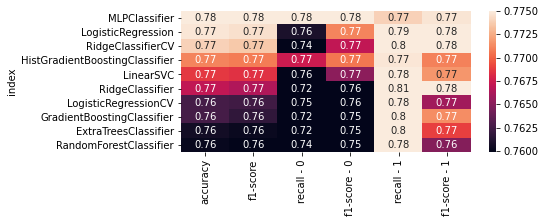

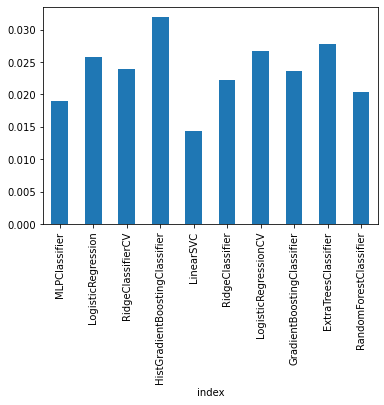

In [32]:
df, avg_df, std_df = avg_eval(X_label, Y, subclass_size=0.3)

10/10 models evaluated


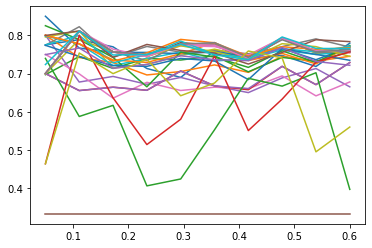

In [35]:
test_size_eval(X_label, Y)

9/10 iterations


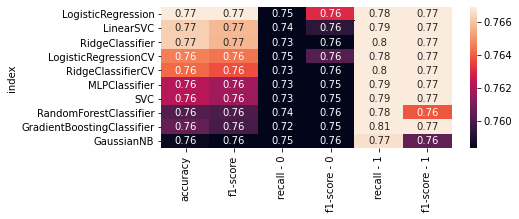

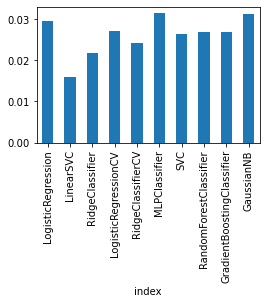

In [36]:
df, avg_df, std_df = avg_eval(X_norm, Y, subclass_size=0.3)

10/10 models evaluated


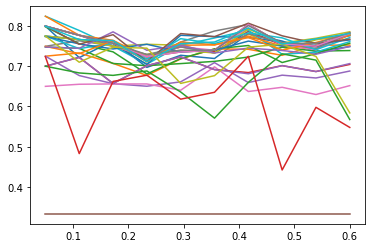

In [37]:
test_size_eval(X_norm, Y)

9/10 iterations


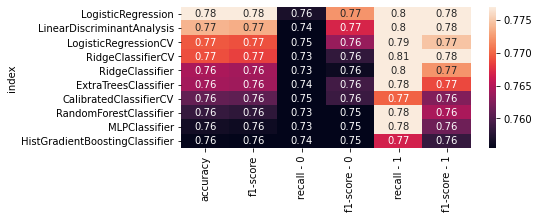

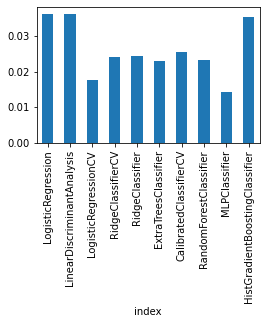

In [38]:
df, avg_df, std_df = avg_eval(X_max, Y, subclass_size=0.3)

10/10 models evaluated


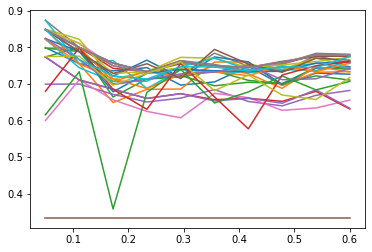

In [39]:
test_size_eval(X_max, Y)

## Exploratory Data Analysis

In [63]:
import itertools

In [77]:
def feature_space_3d(space, X, Y, sample=500):
    
    xx, yy ,zz = space
    Y = Y.sample(sample)
    idx_0 = Y[Y==0].index; idx_1 = Y[Y==1].index

    for angle in range(0,360,6):

        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(projection='3d')

        ax.scatter(X_norm[xx][idx_0], X_norm[yy][idx_0], X_norm[zz][idx_0], color='b')
        ax.scatter(X_norm[xx][idx_1], X_norm[yy][idx_1], X_norm[zz][idx_1], color='r')
        ax.set(xlabel=xx, ylabel=yy, zlabel=zz)

        ax.view_init(angle, angle/9)

        plt.show()
        plt.pause(.1)
        clear_output(wait=True)

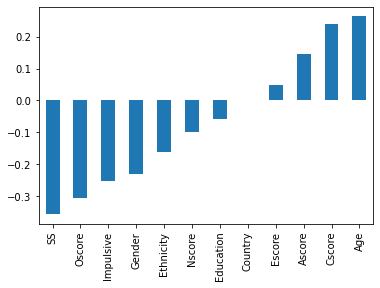

In [62]:
pd.concat([X_max, Y], 1).corr()[Y.name].sort_values()[:-1].plot.bar()

In [94]:
top_corr = pd.concat([X_max, Y], 1).corr()[Y.name].apply(lambda x: x if x>0 else -x).sort_values(ascending=False)[1:].head(5).index
combs = list(itertools.combinations(top_corr, 3))

In [82]:
space = ['Age', 'Oscore', 'SS']
feature_space_3d(space, X_norm, Y, sample=500)

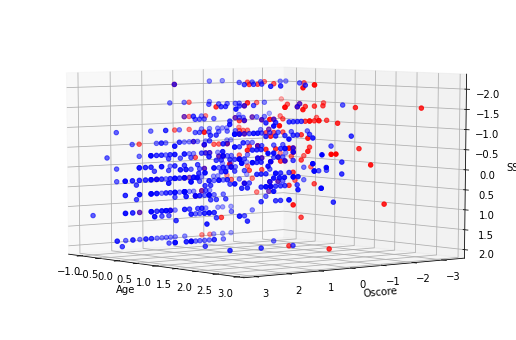

In [85]:
feature_space_3d(['Impulsive', 'Oscore', 'SS'], X_norm, Y, sample=700)

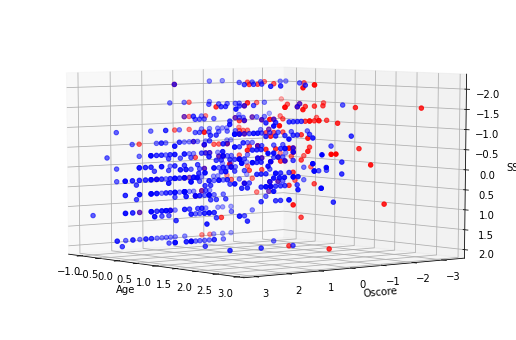

In [85]:
feature_space_3d(['Impulsive', 'Oscore', 'SS'], X_norm, Y, sample=700)